# DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter

# 蒸馏BERT,一个蒸馏版本的BERT:更小、更快、更便宜、更轻

# Abstract

# 摘要



As Transfer Learning from large-scale pre-trained models becomes more prevalent in Natural Language Processing (NLP), operating these large models in on-theedge and/or under constrained computational training or inference budgets remains challenging. In this work, we propose a method to pre-train a smaller generalpurpose language representation model, called DistilBERT, which can then be finetuned with good performances on a wide range of tasks like its larger counterparts. While most prior work investigated the use of distillation for building task-specific models, we leverage knowledge distillation during the pre-training phase and show that it is possible to reduce the size of a BERT model by 40%, while retaining 97% of its language understanding capabilities and being 60% faster. To leverage the inductive biases learned by larger models during pre-training, we introduce a triple loss combining language modeling, distillation and cosine-distance losses. Our smaller, faster and lighter model is cheaper to pre-train and we demonstrate its capabilities for on-device computations in a proof-of-concept experiment and a comparative on-device study.

随着在自然语言处理(NLP)中从大规模预训练模型中进行迁移学习变得越来越普遍，在边缘和/或受限的计算训练或推理预算下操作这些大型模型仍然具有挑战性。在这项工作中，我们提出了一种方法来预先训练一个更小的通用语言表示模型，称为DistilBERT，它可以像其他更大的模型一样在更广泛的任务中表现良好。虽然之前的大多数工作都在研究如何使用精馏来构建特定于任务的模型，但我们在预训练阶段利用了知识精馏，并表明可以将BERT模型的大小减少40%，同时保留97%的语言理解能力并提高60%的速度。为了利用较大模型在预训练学习到的归纳偏差，我们引入了结合语言建模、蒸馏和余弦距离损失的三重损失。我们的模型更小、更快、更轻，预训成本更低，我们通过概念验证实验和设备上的比较研究，展示了它在设备上计算的能力。



# 1 Introduction

# 1介绍

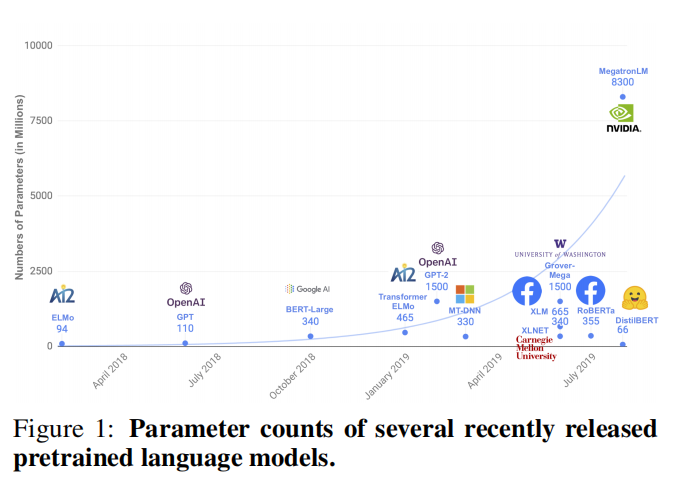

The last two years have seen the rise of Transfer Learning approaches in Natural Language Processing (NLP) with large-scale pre-trained language models becoming a basic tool in many NLP tasks [Devlin et al., 2018, Radford et al., 2019, Liu et al., 2019]. While these models lead to signifi- cant improvement, they often have several hundred million parameters and current research1 on pre-trained models indicates that training even larger models still leads to better performances on downstream tasks.

在过去的两年里，自然语言处理(NLP)中出现了迁移学习方法，大规模的预训练语言模型成为许多NLP任务的基本工具[Devlin et al.， 2018, Radford et al.， 2019, Liu et al.， 2019]。虽然这些模型带来了显著的改进，但它们往往有数亿个参数，目前对预先训练过的模型的研究表明，即使训练更大的模型，仍能提高下游任务的性能。



The trend toward bigger models raises several concerns. First is the environmental cost of exponentially scaling these models’ computational requirements as mentioned in Schwartz et al. [2019], Strubell et al. [2019]. Second, while operating these models on-device in real-time has the potential to enable novel and interesting language processing applications, the growing computational and memory requirements of these models may hamper wide adoption.

更大模型的趋势引发了一些担忧。首先是Schwartz等人[2019]、Strubell等人[2019]提到的指数扩展这些模型的计算需求的环境成本。其次，尽管在设备上实时操作这些模型有可能实现新颖和有趣的语言处理应用程序，但这些模型不断增长的计算和内存需求可能会阻碍其广泛应用。



In this paper, we show that it is possible to reach similar performances on many downstream-tasks using much smaller language models pre-trained with knowledge distillation, resulting in models that are lighter and faster at inference time, while also requiring a smaller computational training budget. Our general-purpose pre-trained models can be fine-tuned with good performances on several downstream tasks, keeping the flexibility of larger models. We also show that our compressed models are small enough to run on the edge, e.g. on mobile devices.

在这篇论文中，我们证明了在许多下游任务中使用更小的用知识蒸馏预训练过的语言模型是有可能达到类似的性能的，从而使模型在推理时更轻、更快，同时也需要更小的计算训练预算。我们的通用预训练模型可以进行微调，在几个下游任务上表现良好，保持了较大模型的灵活性。我们还展示了我们的压缩模型足够小，可以在边缘上运行，例如在移动设备上。



Using a triple loss, we show that a 40% smaller Transformer (Vaswani et al. [2017]) pre-trained through distillation via the supervision of a bigger Transformer language model can achieve similar performance on a variety of downstream tasks, while being 60% faster at inference time. Further ablation studies indicate that all the components of the triple loss are important for best performances. We have made the trained weights available along with the training code in the Transformers2 library from HuggingFace [Wolf et al., 2019].

通过使用三重损失，我们证明了一个40%的较小的Transformer (Vaswani et al.[2017])在一个更大的Transformer语言模型的监督下通过蒸馏进行预训练，可以在各种下游任务中获得类似的性能，同时在推断时间上快60%。进一步的消融研究表明，三重损失的所有组成部分对最佳性能都很重要。我们在HuggingFace [Wolf et al.， 2019]的Transformers2库中提供了训练权重和训练代码。

# 2 Knowledge distillation

# 2 知识蒸馏



Knowledge distillation [Bucila et al., 2006, Hinton et al., 2015] is a compression technique in which a compact model - the student - is trained to reproduce the behaviour of a larger model - the teacher - or an ensemble of models.

知识蒸馏[Bucila et al.， 2006, Hinton et al.， 2015]是一种压缩技术，在这种技术中，一个紧凑的模型(学生)被训练来重现一个更大的模型(老师)或模型集合的行为。



In supervised learning, a classification model is generally trained to predict an instance class by maximizing the estimated probability of gold labels. A standard training objective thus involves minimizing the cross-entropy between the model’s predicted distribution and the one-hot empirical distribution of training labels. A model performing well on the training set will predict an output distribution with high probability on the correct class and with near-zero probabilities on other classes. But some of these "near-zero" probabilities are larger than others and reflect, in part, the generalization capabilities of the model and how well it will perform on the test set.

在监督学习中，分类模型通常通过最大化gold标签的估计概率来预测实例类。因此，标准的训练目标包括最小化模型的预测分布和训练标签的单一经验分布之间的交叉熵。在训练集上表现良好的模型可以预测在正确的类上具有高概率的输出分布，而在其他类上具有接近于零的概率。但其中一些“接近于零”的概率比其他的大，部分反映了模型的泛化能力以及它在测试集上的表现。



Training loss The student is trained with a distillation loss over the soft target probabilities of the teacher: Lce = sigma(i) ti ∗ log(si) where ti (resp. si) is a probability estimated by the teacher (resp. the student). This objective results in a rich training signal by leveraging the full teacher distribution. Following Hinton et al. [2015] we used a softmax-temperature: pi = exp(zi/T) / sigma(j)exp(zj /T) where T controls the smoothness of the output distribution and zi is the model score for the class i. The same temperature T is applied to the student and the teacher at training time, while at inference, T is set to 1 to recover a standard softmax.

训练损失学生被训练一个蒸馏损失除以教师的软目标概率:Lce = sigma(i) ti * log(si)其中ti (resp)si)是老师估计的概率(resp)。学生)。这一目标通过充分利用教师分布，产生了丰富的训练信号。辛顿et al。[2015]我们使用softmax-temperature:pi = exp(zi/T) / sigma(j)exp(zj /T) , T控制输出分布的平滑度和zi是模型在第i类的得分。相同的温度T是应用到学生和老师在训练时,在推理时,T是恢复标准softmax设置为1。



The final training objective is a linear combination of the distillation loss Lce with the supervised training loss, in our case the masked language modeling loss Lmlm [Devlin et al., 2018]. We found it beneficial to add a cosine embedding loss (Lcos) which will tend to align the directions of the student and teacher hidden states vectors.

最终的训练目标是蒸馏损失Lce和监督训练损失的线性组合，在我们的例子中是Masked语言建模损失Lmlm [Devlin et al.， 2018]。我们发现增加余弦嵌入损失(Lcos)是有益的，它将倾向于对齐学生和教师隐藏状态向量的方向。

# 3 DistilBERT: a distilled version of BERT

# 3 蒸馏BERT:蒸馏版的 BERT



Student architecture In the present work, the student - DistilBERT - has the same general architecture as BERT. The token-type embeddings and the pooler are removed while the number of layers is reduced by a factor of 2. Most of the operations used in the Transformer architecture (linear layer and layer normalisation) are highly optimized in modern linear algebra frameworks and our investigations showed that variations on the last dimension of the tensor (hidden size dimension) have a smaller impact on computation efficiency (for a fixed parameters budget) than variations on other factors like the number of layers. Thus we focus on reducing the number of layers.

学生模型结构 在目前的工作中，学生模型-蒸馏BERT-和BERT有相同的一般结构。删除了token类型嵌入和池化(NSP任务)，同时将层数减少了2倍。Transformer中使用的大多数操作体系结构(线性层和layer normalisation)在现代高度优化的线性代数框架和我们的调查显示,张量的变化在最后维度(隐藏的尺寸大小)对计算效率的影响较小(一个固定参数的预算)比变化等其他因素层的数量。因此，我们关注于减少层的数量。



Student initialization In addition to the previously described optimization and architectural choices, an important element in our training procedure is to find the right initialization for the sub-network to converge. Taking advantage of the common dimensionality between teacher and student networks, we initialize the student from the teacher by taking one layer out of two.

学生模型初始化  除了前面描述的优化和架构选择之外，我们的训练过程中的一个重要元素是找到子网络聚合的正确初始化。利用教师网络和学生网络之间的公共维度，我们通过从两个层中取出一个层来初始化来自教师的学生。



Distillation We applied best practices for training BERT model recently proposed in Liu et al. [2019]. As such, DistilBERT is distilled on very large batches leveraging gradient accumulation (up to 4K examples per batch) using dynamic masking and without the next sentence prediction objective.

我们应用最佳实践来训练BERT模型，该模型最近在Liu等人[2019]中提出。因此，利用动态masking技术(每批可达4K个示例)以非常大的批进行蒸馏，无需下一个句子预测目标。



Data and compute power We train DistilBERT on the same corpus as the original BERT model: a concatenation of English Wikipedia and Toronto Book Corpus [Zhu et al., 2015]. DistilBERT was trained on 8 16GB V100 GPUs for approximately 90 hours. For the sake of comparison, the RoBERTa model [Liu et al., 2019] required 1 day of training on 1024 32GB V100.

我们在与原始BERT模型相同的语料库上训练DistilBERT:合并英文维基百科和多伦多图书语料库[Zhu et al.， 2015]。DistilBERT在8个16GB V100 gpu上训练了大约90个小时。为了便于比较，RoBERTa模型[Liu et al.， 2019]要求在1024 32GB V100上进行1天的训练。

# 4 Experiments

# 4 实验



General Language Understanding We assess the language understanding and generalization capabilities of DistilBERT on the General Language Understanding Evaluation (GLUE) benchmark [Wang et al., 2018], a collection of 9 datasets for evaluating natural language understanding systems. We report scores on the development sets for each task by fine-tuning DistilBERT without the use of ensembling or multi-tasking scheme for fine-tuning (which are mostly orthogonal to the present work). We compare the results to the baseline provided by the authors of GLUE: an ELMo (Peters et al. [2018]) encoder followed by two BiLSTMs.

我们在通用语言理解评估基准(GLUE)上评估了DistilBERT的语言理解和综合能力[Wang et al.， 2018]，这是一个用于评估自然语言理解系统的9个数据集。我们通过微调DistilBERT报告每个任务的开发集的得分，没有使用集成或多任务方案进行微调(这与目前的工作大多是正交的)。我们将结果与GLUE: an ELMo (Peters et al.[2018])编码器和两个BiLSTMs .的作者提供的基线进行比较。



The results on each of the 9 tasks are showed on Table 1 along with the macro-score (average of individual scores). Among the 9 tasks, DistilBERT is always on par or improving over the ELMo baseline (up to 19 points of accuracy on STS-B). DistilBERT also compares surprisingly well to BERT, retaining 97% of the performance with 40% fewer parameters.

这9个任务的每个任务的结果都显示在表1中，以及宏观得分(个人得分的平均值)。在这9个任务中，馏分总是在ELMo基线水平或改进(在STS-B上达到19个精度点)。与BERT相比，DistilBERT的性能也出奇地好，在参数减少40%的情况下保留了97%的性能。

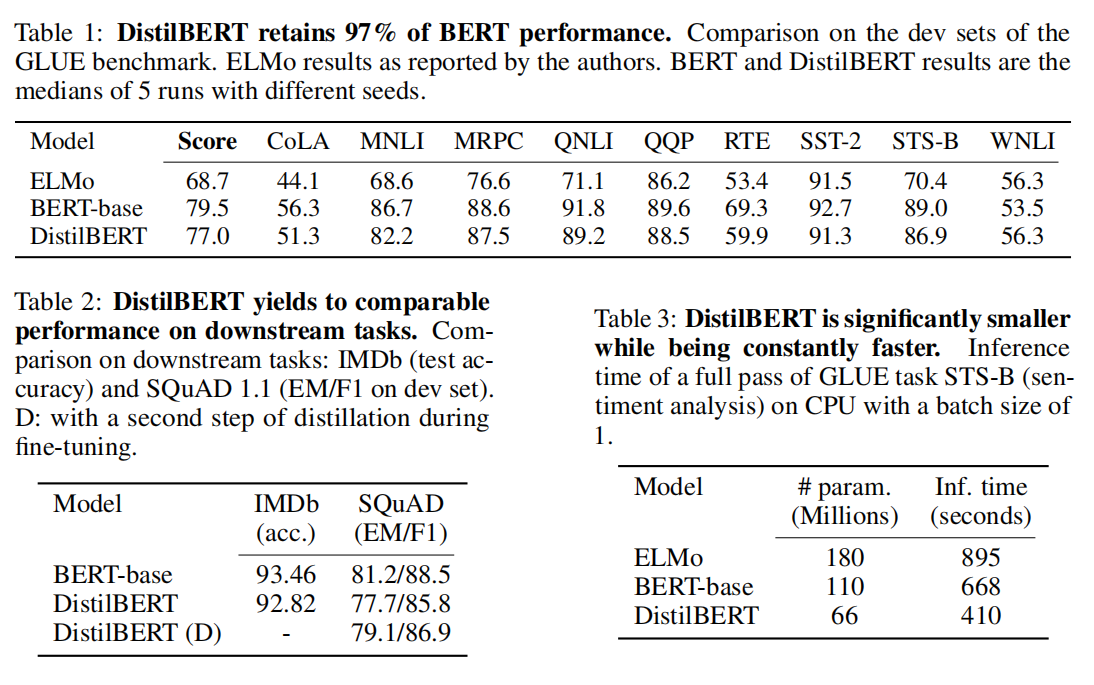

## 4.1 Downstream task benchmark

## 4.1下游任务基准



Downstream tasks We further study the performances of DistilBERT on several downstream tasks under efficient inference constraints: a classification task (IMDb sentiment classification - Maas et al. [2011]) and a question answering task (SQuAD v1.1 - Rajpurkar et al. [2016]).

我们进一步研究了在有效推理约束下，DistilBERT在几个下游任务上的表现:一个分类任务(IMDb sentiment classification - Maas et al.[2011])和一个问题回答任务(SQuAD v1.1 - Rajpurkar et al.[2016])。



As shown in Table 2, DistilBERT is only 0.6% point behind BERT in test accuracy on the IMDb benchmark while being 40% smaller. On SQuAD, DistilBERT is within 3.9 points of the full BERT.

如表2所示，在IMDb基准上，DistilBERT的测试精度仅比BERT低0.6%，比BERT低40%。在 SQuAD中，DistilBERT的得分与满分相差3.9分。



We also studied whether we could add another step of distillation during the adaptation phase by fine-tuning DistilBERT on SQuAD using a BERT model previously fine-tuned on SQuAD as a  teacher for an additional term in the loss (knowledge distillation). In this setting, there are thus two successive steps of distillation, one during the pre-training phase and one during the adaptation phase. In this case, we were able to reach interesting performances given the size of the model: 79.8 F1 and 70.4 EM, i.e. within 3 points of the full model.

我们还研究了在适应阶段是否可以添加另一个蒸馏步骤，即使用之前作为教师对SQuAD进行微调的BERT模型对其进行微调(知识蒸馏)。在这种情况下，有两个连续的蒸馏步骤，一个在预训练阶段，另一个在适应阶段。在这种情况下，我们能够达到有趣的性能给定模型的大小:79.8 F1和70.4 EM，即在3点的完整模型。



Size and inference speed

大小和推理速度



To further investigate the speed-up/size trade-off of DistilBERT, we compare (in Table 3) the number of parameters of each model along with the inference time needed to do a full pass on the STSB development set on CPU (Intel Xeon E5-2690 v3 Haswell @2.9GHz) using a batch size of 1. DistilBERT has 40% fewer parameters than BERT and is 60% faster than BERT.

为了进一步研究DistilBERT的加速/大小权衡，我们使用批处理大小为1，比较(在表3中)每个模型的参数数量以及在CPU (Intel Xeon E5-2690 v3 Haswell @2.9GHz)上对STSB开发集进行完整传递所需的推理时间。DistilBERT的参数比BERT少40%，比BERT快60%。



On device computation 

在设备计算



We studied whether DistilBERT could be used for on-the-edge applications by building a mobile application for question answering. We compare the average inference time on a recent smartphone (iPhone 7 Plus) against our previously trained question answering model based on BERT-base. Excluding the tokenization step, DistilBERT is 71% faster than BERT, and the whole model weighs 207 MB (which could be further reduced with quantization). Our code is available.

我们通过构建一个用于问题回答的移动应用程序，研究了DistilBERT是否可以用于边缘应用程序。我们将最近的智能手机(iPhone 7 Plus)的平均推断时间与我们之前训练的基于BERT-base的问题回答模型进行了比较。除去标记化步骤，DistilBERT比BERT快71%，整个模型的重量为207mb(量化可以进一步降低)。我们的代码是可用的。



## 4.2 Ablation study

## 4.2消融研究


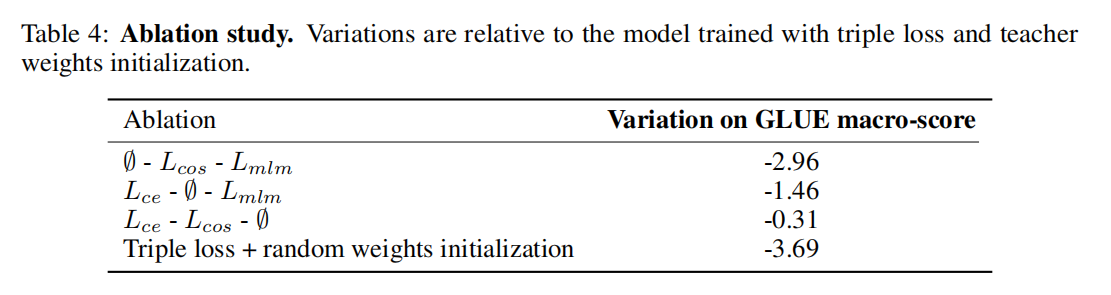

In this section, we investigate the influence of various components of the triple loss and the student initialization on the performances of the distilled model. We report the macro-score on GLUE. Table 4 presents the deltas with the full triple loss: removing the Masked Language Modeling loss has little impact while the two distillation losses account for a large portion of the performance.

在这一节中，我们研究了三重损失的不同组成部分和学生模型初始化对所提取的模型的性能的影响。我们报告了在GLUE上的宏观评分。表4给出了具有完整三重损失的差异:除去屏蔽语言建模损失的影响很小，而这两种损失占了性能的很大一部分。

# 5 Related work 

# 5 相关工作



Task-specific distillation Most of the prior works focus on building task-specific distillation setups. Tang et al. [2019] transfer fine-tune classification model BERT to an LSTM-based classifier. Chatterjee [2019] distill BERT model fine-tuned on SQuAD in a smaller Transformer model previously initialized from BERT. In the present work, we found it beneficial to use a general-purpose pre-training distillation rather than a task-specific distillation. Turc et al. [2019] use the original pretraining objective to train smaller student, then fine-tuned via distillation. As shown in the ablation study, we found it beneficial to leverage the teacher’s knowledge to pre-train with additional distillation signal. 

特定任务的蒸馏大多数先前的工作集中于建立特定任务的蒸馏设置。Tang等[2019]将微调分类模型BERT转换为基于lstm的分类器。Chatterjee[2019]提取了BERT模型，在之前由BERT初始化的一个更小的Transformer模型中对SQuAD进行了微调。在目前的工作中，我们发现使用通用的预训练蒸馏而不是特定任务的蒸馏是有益的。Turc等人[2019]使用原始的预训练目标来训练较小的学生模型，然后通过蒸馏进行微调。如消融研究所示，我们发现利用教师的知识以附加的蒸馏信号进行预训练是有益的。



Multi-distillation Yang et al. [2019] combine the knowledge of an ensemble of teachers using multi-task learning to regularize the distillation. The authors apply Multi-Task Knowledge Distillation to learn a compact question answering model from a set of large question answering models. An application of multi-distillation is multi-linguality: Tsai et al. [2019] adopts a similar approach to us by pre-training a multilingual model from scratch solely through distillation. However, as shown in the ablation study, leveraging the teacher’s knowledge with initialization and additional losses leads to substantial gains.

Yang等人[2019]结合教师团队的知识，使用多任务学习来调节蒸馏。利用多任务知识提取的方法，从一组大型问题回答模型中学习了一个紧凑的问题回答模型。多语言精馏的一个应用是多语言性:Tsai等人[2019]采用了与我们类似的方法，仅通过精馏就从头开始对多语言模型进行预训练。然而，消融研究表明，利用教师的知识初始化和额外的损失导致实质性的收益。



Other compression techniques have been studied to compress large models. Recent developments in weights pruning reveal that it is possible to remove some heads in the self-attention at test time without significantly degrading the performance Michel et al. [2019]. Some layers can be reduced to one head. A separate line of study leverages quantization to derive smaller models (Gupta et al. [2015]). Pruning and quantization are orthogonal to the present work.

其他压缩技术也被研究用于压缩大型模型。最近在权重剪枝方面的发展表明，在不显著降低性能的情况下，在测试时去除一些自我注意中的头是可能的。Michel等人[2019]。有些层可以减少到一个头。另一项独立的研究利用量化得出更小的模型(Gupta等人[2015])。以目前的工作,剪枝和量化是正交的。


# 6 Conclusion and future work

# 6 结论与未来工作



We introduced DistilBERT, a general-purpose pre-trained version of BERT, 40% smaller, 60% faster, that retains 97% of the language understanding capabilities. We showed that a general-purpose language model can be successfully trained with distillation and analyzed the various components with an ablation study. We further demonstrated that DistilBERT is a compelling option for edge appplications.

我们引入了一个通用的预先训练版本的“蒸馏BERT”(DistilBERT)，它比“BERT”小40%，快60%，保留了97%的语言理解能力。我们证明了一个通用语言模型可以通过精馏成功地训练，并通过消融研究分析了各种成分。我们进一步证明，DistilBERT是一个引人注目的选择边缘应用。